# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [1]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



ModuleNotFoundError: No module named 'kagglehub'

## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [3]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  


____

### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


#### **1.1:  What is the objective of this project in business terms?**

The objective of this project is to use various home features from Zillow’s housing database to build a model that accurately predicts the total assessed value of a property (taxvaluedollarcnt). This prediction helps improve the accuracy of the Zestimate—Zillow’s home valuation tool—which gives users a quick estimate of their home’s value based on comparable properties and current market conditions. From a business perspective, a more accurate Zestimate increases user trust, improves engagement on the platform, and helps buyers and sellers make informed decisions about whether a home is fairly priced.


#### **1.2:  How will your solution be used?**

Once the model is complete, it will be integrated into Zillow’s user-facing Zestimate tool, which provides homeowners with a free estimate of their property’s value based on similar homes and market trends. This offers a convenient alternative to paid appraisals and helps users track value appreciation over time. Buyers can also use the Zestimate to compare listing prices against market-based estimates, helping them judge whether a property is overpriced or a potential deal. 


#### **1.3:  How should success (or failure) be measured?**

Success for this exercise should be measured by how accurately the model predicts the actual assessed value of a property (taxvaluedollarcnt). This can be evaluated using regression metrics such as  or Root Mean Squared Error (RMSE) or Mean Absolute Error (MAE), which quantify how close the model’s predictions are to the true values. A lower error indicates a more reliable Zestimate, which translates to better user trust and utility.

___

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

#### **Preliminary Data Analysis**

In [4]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

#### **Preliminary Data Analysis: Null Feature Counts**

In [6]:
def show_null_counts_features(df):
    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)
    
    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')
    
    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        'Null Values': count_nulls[count_nulls > 0].values,  # match print statement
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)
    
    print(f'The dataset contains {len(df)} samples.\n')
    
    if len(missing_data) == 0:
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print(f"{'Feature':<30} {'Null Values':>12} {'Null %':>10} {'Type':>10}")
        print("-" * 70)
        for _, row in missing_data.iterrows():
            print(
                f"{row['Feature']:<30} "
                f"{row['Null Values']:>12} "
                f"{row['Null %']:>10} "
                f"{row['Type']:>10}"
            )

In [7]:
show_null_counts_features(df)

The dataset contains 77613 samples.

Feature                         Null Values     Null %       Type
----------------------------------------------------------------------
buildingclasstypeid                   77598      99.98    Numeric
finishedsquarefeet13                  77571      99.95    Numeric
basementsqft                          77563      99.94    Numeric
storytypeid                           77563      99.94    Numeric
yardbuildingsqft26                    77543      99.91    Numeric
fireplaceflag                         77441      99.78 Categorical
architecturalstyletypeid              77406      99.73    Numeric
typeconstructiontypeid                77390      99.71    Numeric
finishedsquarefeet6                   77227       99.5    Numeric
pooltypeid10                          77148       99.4    Numeric
decktypeid                            76999      99.21    Numeric
poolsizesum                           76744      98.88    Numeric
pooltypeid2                      

In [8]:
# ========================================================================================
# This is meant to consolidate the 'show_null_counts_features' function from before with 
# another with 'value' and 'unique' counts later on in this analysis. 
# ========================================================================================

def profile_dataset(df):
    # Identify feature types
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')

    # Build a summary DataFrame
    summary = pd.DataFrame({
        'Feature': df.columns,
        'Type': feature_types.values,
        'Null Values': df.isnull().sum().values,
        'Null %': (df.isnull().mean() * 100).round(2).values,
        'Count (Non-Null)': df.count().values,
        'Unique Values': df.nunique().values
    })

    # Sort Values in Summary by % of null values
    summary = summary.sort_values(by='Null %', ascending=False).reset_index(drop=True)

    # Add dataset shape info above the table
    print(f"Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

    # Display the summary
    return summary

In [9]:
profile_dataset(df)

Dataset shape: 77613 rows × 55 columns



,Feature,Type,Null Values,Null %,Count (Non-Null),Unique Values
0,buildingclasstypeid,Numeric,77598,99.98,15,2
1,finishedsquarefeet13,Numeric,77571,99.95,42,13
2,basementsqft,Numeric,77563,99.94,50,43
3,storytypeid,Numeric,77563,99.94,50,1
4,yardbuildingsqft26,Numeric,77543,99.91,70,59
5,fireplaceflag,Categorical,77441,99.78,172,1
6,architecturalstyletypeid,Numeric,77406,99.73,207,5
7,typeconstructiontypeid,Numeric,77390,99.71,223,4
8,finishedsquarefeet6,Numeric,77227,99.50,386,350
9,pooltypeid10,Numeric,77148,99.40,465,1


In [10]:
df_numeric = df.select_dtypes(include=['number'])
df_categorical = df.select_dtypes(exclude=['number'])

In [11]:
df_categorical['fireplaceflag'].unique()

array([nan, True], dtype=object)

In [12]:
# Summarize the datasets using describe()
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
parcelid,77613.0,1.300781e+07,3.518717e+06,1.071186e+07,1.153821e+07,1.253004e+07,1.421101e+07,1.676893e+08
airconditioningtypeid,25007.0,1.812013e+00,2.965768e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,207.0,7.386473e+00,2.728030e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03
bathroomcnt,77579.0,2.298496e+00,9.967317e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,77579.0,3.053223e+00,1.140480e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
buildingqualitytypeid,49809.0,6.533779e+00,1.722062e+00,1.000000e+00,6.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,76963.0,2.316392e+00,9.796893e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
decktypeid,614.0,6.600000e+01,0.000000e+00,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01


In [13]:
print(f"This dataset contain {df.shape[0]} rows")
print(f"This dataset contain {df.shape[1]} columns")

# basic aggregates
data_profiling = df.agg(['count', 'nunique']).transpose()
data_profiling

This dataset contain 77613 rows
This dataset contain 55 columns


,count,nunique
parcelid,77613,77414
airconditioningtypeid,25007,5
architecturalstyletypeid,207,5
basementsqft,50,43
bathroomcnt,77579,22
bedroomcnt,77579,16
buildingclasstypeid,15,2
buildingqualitytypeid,49809,12
calculatedbathnbr,76963,21
decktypeid,614,1


In [14]:
data_profiling_unique_columns = data_profiling[data_profiling['count'] == data_profiling['nunique']]
print(data_profiling_unique_columns)

Empty DataFrame
Columns: [count, nunique]
Index: []


In [15]:
number_of_duplicates = df['parcelid'].duplicated().sum()

# show duplicated if any:
if  number_of_duplicates > 0:
    print(f"Number of duplicated Rows: {number_of_duplicates:,d}")    
else:
    print("No duplicates found.")
df_duplicates = df[df['parcelid'].duplicated()]

df_duplicates.head()

Number of duplicated Rows: 199


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
117,11393337,NaN,NaN,NaN,3.0,3.0,NaN,4.0,3.0,NaN,...,NaN,NaN,1940.0,NaN,NaN,2016.0,Y,14.0,6.037235e+13,43439.0
625,14634203,1.0,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1974.0,1.0,NaN,2016.0,NaN,NaN,6.059001e+13,289445.0
1018,11721753,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,NaN,...,NaN,NaN,1923.0,NaN,NaN,2016.0,NaN,NaN,6.037220e+13,205123.0
1248,11289917,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,Y,15.0,6.037901e+13,136104.0
1734,11637029,1.0,NaN,NaN,2.0,3.0,NaN,9.0,2.0,NaN,...,NaN,NaN,1980.0,NaN,NaN,2016.0,Y,13.0,6.037701e+13,810694.0


In [16]:
df_unique = df.drop_duplicates(subset=['parcelid'], keep='last')
df_unique.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


#### **2.A Discussion:** Answer the following questions.

**2.A.1:  Which features are categorical?**

The following features are categorical: 
- **hashottuborspa**
    - boolean -- either nan or True
    - 98.02 % null

- **propertycountylandusecode**
    - 75 distinct property codes
    - 0.04% null

- **propertyzoningdesc**
    - 1907 distinct property zoning descriptions
    - 34.96 % null

- **fireplaceflag**
    - boolean -- either nan or True
    - 99.78% null

- **taxdelinquencyflag**
    - boolean -- either nan or Y
    - 96.26% null

**2.A.2:  Are there any features which appear at first glance to be *useless* for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly.**


Yes -- first of all, there are a large number of `ID` columns that are present in our dataset. At this time, we don't have the necessary information to discern what **airconditioningtypeid** or **architecturalstyletypeid** mean in useful terms for the purpose of this analysis -- therefore these columns should be dropped -- especially if they contain a large number of null values as well.

Features **latitude** and **longitude** provide the property's geographic coordinates, which could be geocoded to extract location-based insights, although this process is beyond the scope of the current milestone.

The **propertyzoningdesc** feature provides a description of the property's zoning, but with 1908 unique text codes of uncertain meaning, it is not viable for use in the current milestone without significant preprocessing or grouping.


**2.A.3: Are there any features which appear to be *useless* because of the percentage of missing values?  If so, give an example.**

The following features appear to be uninformative due to the high percentage of missing values. In general, any non-boolean feature with over 60% null values was considered unsuitable for future analysis and will be dropped.

Additionally, a few boolean features (formatted as either True/T or null) were also excluded. While this format is not inherently problematic, each of these features had over 95% null values. With such a high proportion of missing data, it is unclear whether the lack of values is inherent to the variable itself or the result of inconsistent data entry, making them unreliable for analysis.

The boolean-type features excluded for this reason are:

-  fireplaceflag
- hashottuborspa
- taxdelinquencyflag

In summary, the following features will be dropped due to high null percentages and/or data quality concerns:
 

| Feature                      | Null Values | Null % | Type         |
|-----------------------------|-------------|--------|--------------|
| buildingclasstypeid         | 77,598      | 99.98% | Numeric      |
| finishedsquarefeet13        | 77,571      | 99.95% | Numeric      |
| basementsqft                | 77,563      | 99.94% | Numeric      |
| storytypeid                 | 77,563      | 99.94% | Numeric      |
| yardbuildingsqft26          | 77,543      | 99.91% | Numeric      |
| fireplaceflag               | 77,441      | 99.78% | Categorical  |
| architecturalstyletypeid    | 77,406      | 99.73% | Numeric      |
| typeconstructiontypeid      | 77,390      | 99.71% | Numeric      |
| finishedsquarefeet6         | 77,227      | 99.50% | Numeric      |
| pooltypeid10                | 77,148      | 99.40% | Numeric      |
| decktypeid                  | 76,999      | 99.21% | Numeric      |
| poolsizesum                 | 76,744      | 98.88% | Numeric      |
| pooltypeid2                 | 76,539      | 98.62% | Numeric      |
| hashottuborspa              | 76,074      | 98.02% | Categorical  |
| yardbuildingsqft17          | 75,220      | 96.92% | Numeric      |
| taxdelinquencyflag          | 74,713      | 96.26% | Categorical  |
| taxdelinquencyyear          | 74,713      | 96.26% | Numeric      |
| finishedsquarefeet15        | 74,586      | 96.10% | Numeric      |
| finishedsquarefeet50        | 71,576      | 92.22% | Numeric      |
| finishedfloor1squarefeet    | 71,576      | 92.22% | Numeric      |
| fireplacecnt                | 69,324      | 89.32% | Numeric      |
| threequarterbathnbr         | 67,507      | 86.98% | Numeric      |
| pooltypeid7                 | 62,534      | 80.57% | Numeric      |
| poolcnt                     | 61,439      | 79.16% | Numeric      |
| numberofstories             | 60,014      | 77.32% | Numeric      |
| airconditioningtypeid       | 52,606      | 67.78% | Numeric      |
| garagecarcnt                | 52,093      | 67.12% | Numeric      |
| garagetotalsqft             | 52,093      | 67.12% | Numeric      |
| regionidneighborhood        | 46,639      | 60.09% | Numeric      |


#### **Comment / Hypothesis:**
Instead of dropping columns like **fireplaceflag** or other high-null integer/boolean features above, **we can hypothesize that missing values often represent a valid “no” or “zero” state.**

For example, if **fireplaceflag** is null, we can assume it means “no fireplace” and set it to 0 (False). Similarly, for numeric columns like **basementsqft**, a missing value could be treated as 0 to indicate there is no basement. 

We can also create additional indicator columns (e.g., has_fireplace = 1 if not null, otherwise 0) to capture any information in the missingness itself. 

By applying these transformations, we can retain potentially useful features and then empirically evaluate whether they improve our models rather than discarding them outright.

**2.A.4: Are there any features which appear to be *useless* because of the number of unique values?  If so, give an example.**

The following feature variables can probably be droped due to lack of variables: 

 - **assessmentyear** Assessment Year. Only one value, 2016
 - **buildingclasstypeid**: Identifier for the building framing type. 2 unique values and just 15 rows populated. 
 - **storytypeid**: Identifier for the type of stories in the building. 1 identifier in 350 rows.

Variables with too many unique values:
 - **parcelid**: Unique identifier for the property parcel. Primary key, does not have any value for ML.
 - **rawcensustractandblock**: Unprocessed census tract and block identifier. ~39k unique IDs 
 - **censustractandblock**: A combined identifier for the property’s census tract and block group.  ~39k unique IDs 
 - **latitude**: Latitude coordinate of the property.  Out of scope
 - **longitude**: Longitude coordinate of the property.   Out of scope
 - **propertyzoningdesc**: Description of the property's zoning. Descriptive info with 1908 unique text codes.
 - **regionidneighborhood**: Identifier for the neighborhood. 480 ids
 - **regionidzip**: Identifier for the ZIP code.  389 ids. Grouping to states/zones can be implemented. 
 - **regionidcity**: Identifier for the city.  175 city ids. Encoding is manageable but not as part of this milestone.
 - **yearbuilt**: Year the property was built.  136 years. Grouping to decades, plus creating a new feature **propertyage** = **yearbuilt** - **assessmentyear**
 - **propertycountylandusecode**: County land use code for the property. 75 unknown ids. 


Target: 
 - **taxvaluedollarcnt**: Total assessed value of the property in dollars.  

Additionally, most columns containing 'id' in their names can be dropped, as they typically represent either unique identifiers or encoded categorical types that are not interpretable without access to supplementary datasets. For example, a value of 56784 in a column like airconditioningtypeid holds no meaningful distinction from a value like 30495 without a corresponding lookup table.

Without access to such reference data, we cannot interpret these fields in a way that adds value to our analysis. Moreover, these ID fields are often treated as ordinal categorical variables, despite representing unordered categories (e.g., types of air conditioning). Including them in the modeling process could introduce noise or lead to misleading conclusions, so they should be removed from the dataset.

Upon further inspection, there are some additional feature variables that require further inspection before the determination can be made to keep them in the dataset or remove them before moving forward. Variables like yardbuildingsqft17 vs yardbuildingsqft26 should be evaluated further to see if they offer any meaningful information (distinct from each other) towards this analysis. 


#### **Comment / Hypothesis:**
While it's often advised to drop ID fields due to interpretability issues without a lookup table, not all such features should be discarded outright. For instance, **airconditioningtypeid** has only 5 unique values and is populated in 25k rows. 

This suggests that it likely encodes a small set of meaningful categories (e.g., different types of air conditioning), and missing values could be interpreted as "no air conditioning." Instead of dropping it, we can encode this feature as a categorical variable (using one-hot encoding or similar techniques) and validate its contribution to the model. This approach preserves potentially useful information and enables us to test whether the feature adds value to our analysis.

Specifically, for example, we can encode the **airconditioningtypeid** feature into 5 distinct categories representing different types of air conditioning, and also create an additional indicator variable, such as **airconditioning_exists**, which flags whether the property has any air conditioning (i.e., non-missing value) or not (missing value).

___

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

<Figure size 1600x4000 with 0 Axes>

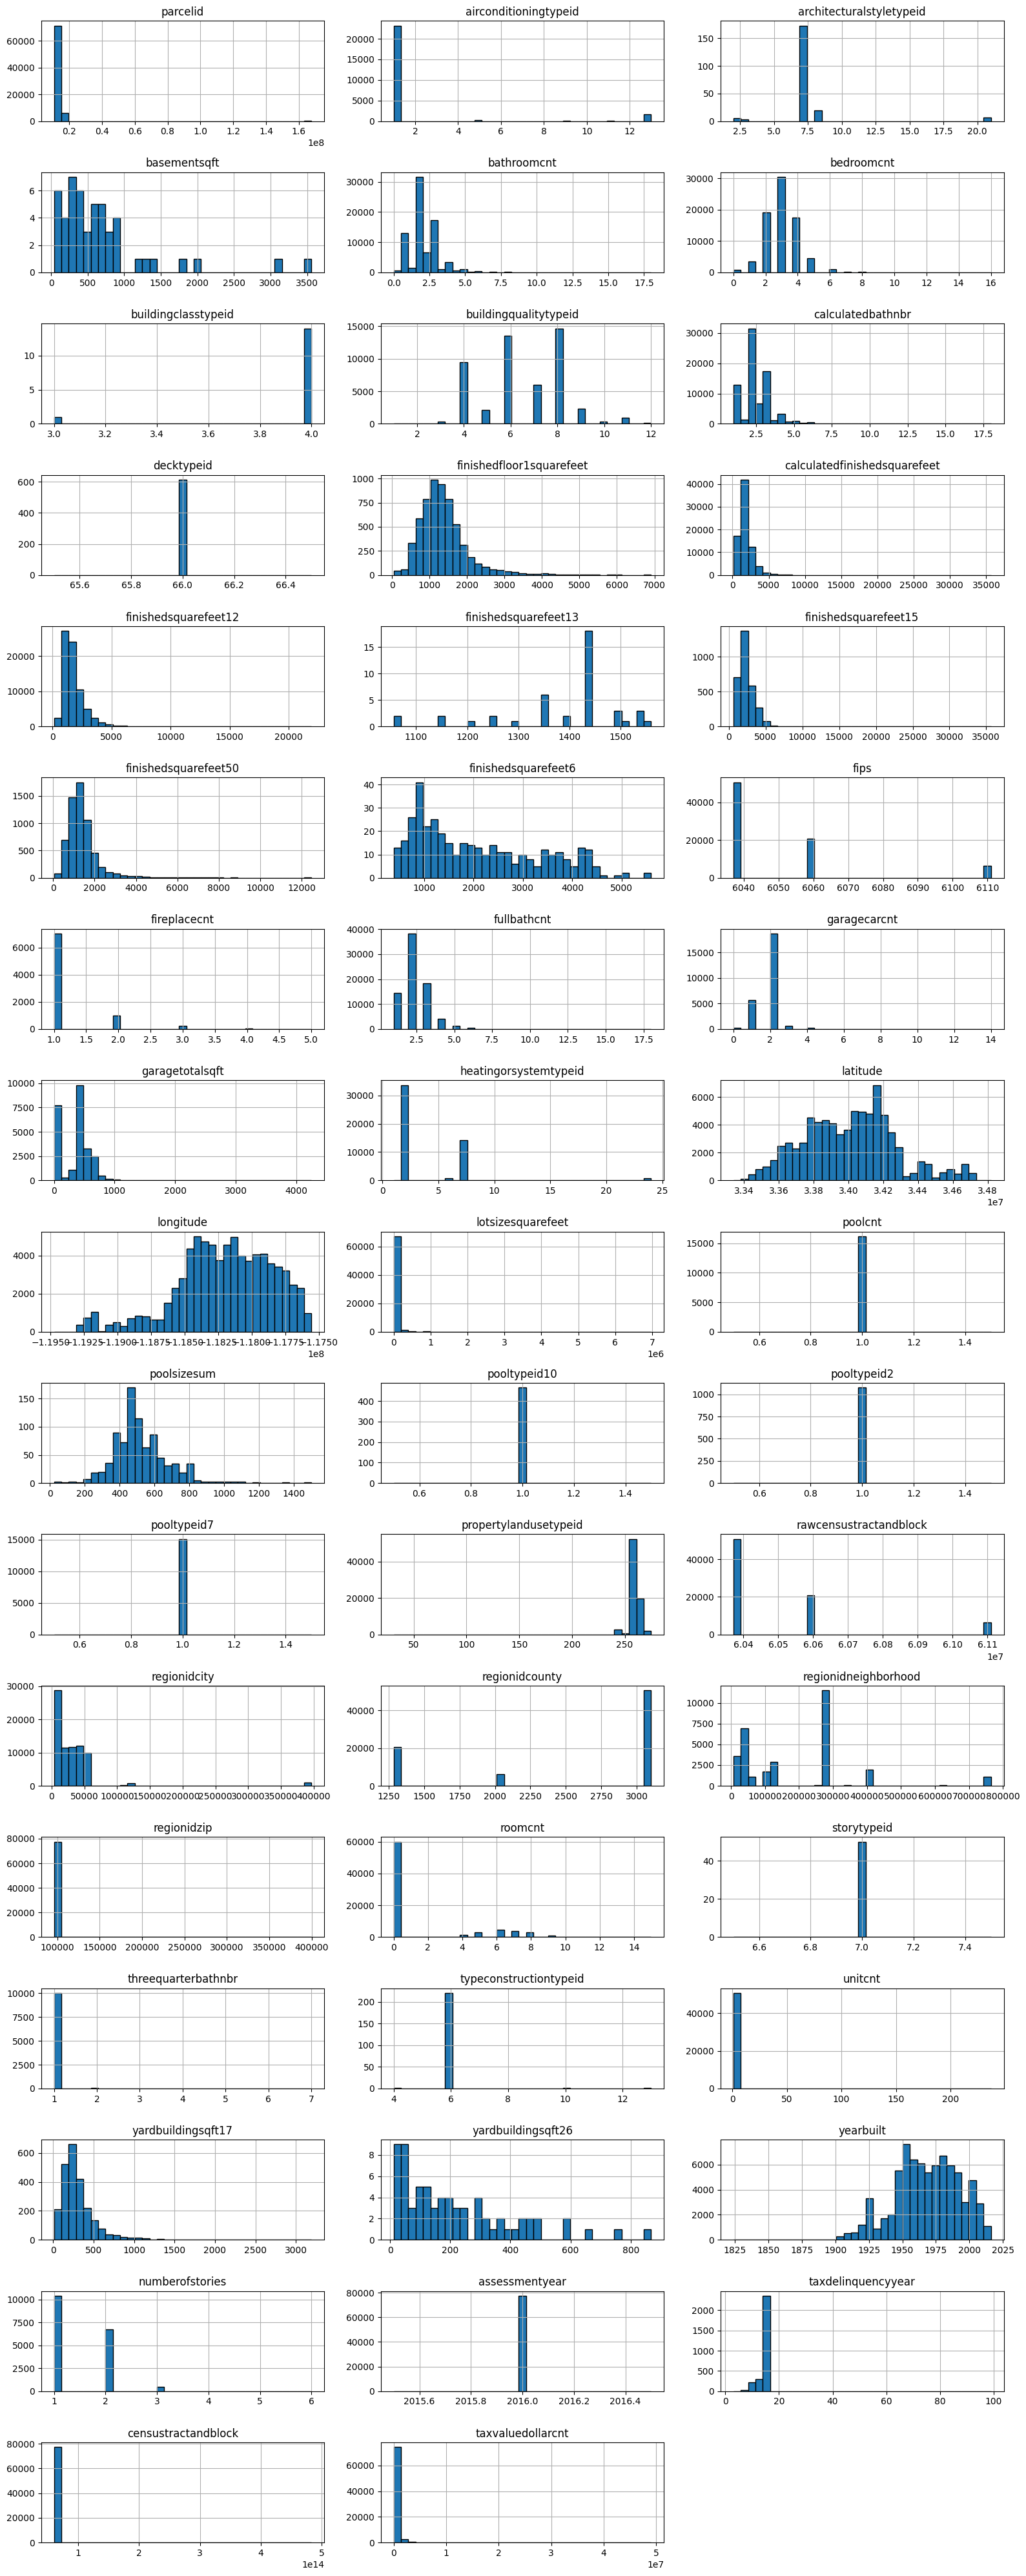

In [17]:
plt.figure(figsize=(16,40))
df_numeric.hist(bins=35, figsize=(16, 40), layout=(-1,3), edgecolor='black')
plt.tight_layout()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [18]:
#######################################
# Preparation for Data Cleaning: 
#######################################
# Create a copy of the original DataFrame
df_clean = df.copy()

def drop_features(dataframe, columns_to_drop):
    initial_columns = dataframe.shape[1]
    # Drop each column gradually, using try-except to avoid errors if the column is missing
    for col in columns_to_drop:
        try:
            dataframe = dataframe.drop(columns=[col])
            print(f"Dropped column: {col}")
        except KeyError:
            print(f"Column {col} not found. Skipping.")
    final_columns = dataframe.shape[1]
    print(f"Number of columns to be dropped: {len(columns_to_drop)}")
    print(f"Number of columns before dropping: {initial_columns}")
    print(f"Number of columns after dropping: {final_columns}")
    return dataframe


In [19]:
def remove_outliers_iqr(df, target_col, lower_mult=1.0, upper_mult=1.5):
    # Compute quartiles and IQR
    Q1 = df[target_col].quantile(0.25)
    Q3 = df[target_col].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate bounds; ensure lower_bound is not negative
    lower_bound = max(Q1 - lower_mult * IQR, 0)
    upper_bound = Q3 + upper_mult * IQR

    # Filter out the outliers deterministically
    df_no_outliers = df[(df[target_col] >= lower_bound) & (df[target_col] <= upper_bound)].copy()
    
    return df_no_outliers, lower_bound, upper_bound

In [20]:
################################################
# Drop features unsuitable for regression task: 
################################################

columns_to_drop_unsuitable = [
    "assessmentyear",            # Only one value, 2016
    "parcelid",                  # Unique identifier; not useful for ML
    "rawcensustractandblock",    # Unprocessed census tract and block; ~39k unique IDs
    "censustractandblock",       # Processed census tract and block; ~39k unique IDs
    "latitude",                  # Out of scope
    "longitude",                 # Out of scope
    "propertyzoningdesc",        # 1908 unique text codes with unknown meaning
    "regionidneighborhood",      # 480 unique values
    "regionidzip",               # 389 unique values (could be grouped, but not for this milestone)
    "regionidcity",              # 175 unique values (encoding manageable, but not part of this milestone)
    "propertycountylandusecode"  # 75 unknown IDs
]


df_clean = drop_features(dataframe=df_clean, columns_to_drop=columns_to_drop_unsuitable).copy()


Dropped column: assessmentyear
Dropped column: parcelid
Dropped column: rawcensustractandblock
Dropped column: censustractandblock
Dropped column: latitude
Dropped column: longitude
Dropped column: propertyzoningdesc
Dropped column: regionidneighborhood
Dropped column: regionidzip
Dropped column: regionidcity
Dropped column: propertycountylandusecode
Number of columns to be dropped: 11
Number of columns before dropping: 55
Number of columns after dropping: 44


#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

- If a feature is missing 90% or more of its data, it is generally considered too unreliable to contribute meaningfully to the analysis.

- If a feature has more than 60% missing data, we need to examine whether the available values are highly informative or critical to the model; in such cases, we might opt to impute the missing data instead of dropping the feature.

In [21]:
################################################
# Drop features with too many missing values: 
################################################

# threshold 90% of missing values: 

columns_to_drop_too_many_missing_90 = [
    "buildingclasstypeid",             #      77598      99.98    Numeric
    "finishedsquarefeet13",            #      77571      99.95    Numeric
    "basementsqft",                    #      77563      99.94    Numeric
    "storytypeid",                     #      77563      99.94    Numeric
    "yardbuildingsqft26",              #      77543      99.91    Numeric
    "fireplaceflag",                   #      77441      99.78 Categorical
    "architecturalstyletypeid",        #      77406      99.73    Numeric
    "typeconstructiontypeid",          #      77390      99.71    Numeric
    "finishedsquarefeet6",             #      77227       99.5    Numeric
    "pooltypeid10",                    #      77148       99.4    Numeric
    "decktypeid",                      #      76999      99.21    Numeric
    "poolsizesum",                     #      76744      98.88    Numeric
    "pooltypeid2",                     #      76539      98.62    Numeric
    "hashottuborspa",                  #      76074      98.02 Categorical
    "yardbuildingsqft17",              #      75220      96.92    Numeric
    "taxdelinquencyflag",              #      74713      96.26 Categorical
    "taxdelinquencyyear",              #      74713      96.26    Numeric
    "finishedsquarefeet15",            #      74586       96.1    Numeric
    "finishedsquarefeet50",            #      71576      92.22    Numeric
    "finishedfloor1squarefeet"         #      71576      92.22    Numeric
]

df_clean = drop_features(dataframe=df_clean, columns_to_drop=columns_to_drop_too_many_missing_90).copy()

# threshold 60% of missing values and values are not useful for regression task:
columns_to_drop_too_many_missing_60 = [
    "fireplacecnt",                    #      69324      89.32    Numeric
    "threequarterbathnbr",             #      67507      86.98    Numeric
    "pooltypeid7",                     #      62534      80.57    Numeric
    "poolcnt",                         #      61439      79.16    Numeric
    "numberofstories",                 #      60014      77.32    Numeric
    "airconditioningtypeid",           #      52606      67.78    Numeric
    "garagecarcnt",                    #      52093      67.12    Numeric
    "garagetotalsqft",                 #      52093      67.12    Numeric
    "regionidneighborhood"             #      46639      60.09    Numeric
]

df_clean = drop_features(dataframe=df_clean, columns_to_drop=columns_to_drop_too_many_missing_60).copy()

Dropped column: buildingclasstypeid
Dropped column: finishedsquarefeet13
Dropped column: basementsqft
Dropped column: storytypeid
Dropped column: yardbuildingsqft26
Dropped column: fireplaceflag
Dropped column: architecturalstyletypeid
Dropped column: typeconstructiontypeid
Dropped column: finishedsquarefeet6
Dropped column: pooltypeid10
Dropped column: decktypeid
Dropped column: poolsizesum
Dropped column: pooltypeid2
Dropped column: hashottuborspa
Dropped column: yardbuildingsqft17
Dropped column: taxdelinquencyflag
Dropped column: taxdelinquencyyear
Dropped column: finishedsquarefeet15
Dropped column: finishedsquarefeet50
Dropped column: finishedfloor1squarefeet
Number of columns to be dropped: 20
Number of columns before dropping: 44
Number of columns after dropping: 24
Dropped column: fireplacecnt
Dropped column: threequarterbathnbr
Dropped column: pooltypeid7
Dropped column: poolcnt
Dropped column: numberofstories
Dropped column: airconditioningtypeid
Dropped column: garagecarcnt

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [22]:
# Parameters
target_col = 'taxvaluedollarcnt'
null_threshold = 0.6
print(f"Null threshold: {null_threshold*100}%")

# Step 1: Drop samples with null values in the target column
print(f"Number of samples before dropping null values in the target: {df_clean.shape[0]:,.0f}")
df_clean = df_clean.dropna(subset=[target_col]).copy()
print(f"Number of samples after dropping null values in the target: {df_clean.shape[0]:,.0f}")


# Step 2: Drop samples with too many null values
print(f"Number of samples before dropping too many null values in the target: {df_clean.shape[0]:,.0f}")
df_clean = df_clean[df_clean.isnull().mean(axis=1) <= null_threshold].copy()
print(f"Number of samples before dropping too many null values in the target: {df_clean.shape[0]:,.0f}")


Null threshold: 60.0%
Number of samples before dropping null values in the target: 77,613
Number of samples after dropping null values in the target: 77,578
Number of samples before dropping too many null values in the target: 77,578
Number of samples before dropping too many null values in the target: 77,578


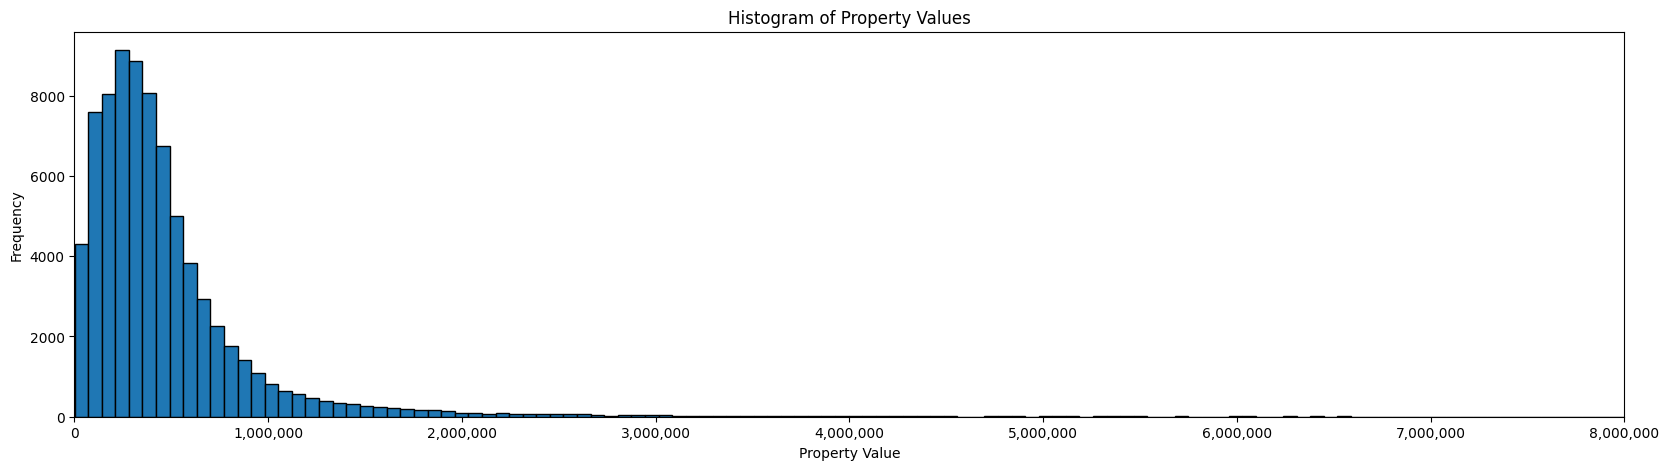

Minimum value of target: 1,000
Maximum value of target: 49,061,236


In [23]:
ax = df_clean[target_col].plot.hist(figsize=(20,5), bins=700, edgecolor='black')

# Use StrMethodFormatter to format the x-axis labels with commas
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

ax.set_xlim([0, 8_000_000])

plt.title("Histogram of Property Values")
plt.xlabel("Property Value")
plt.ylabel("Frequency")

plt.show()
min_val = df_clean[target_col].min()
max_val = df_clean[target_col].max()

print(f"Minimum value of target: {min_val:,.0f}")
print(f"Maximum value of target: {max_val:,.0f}")

This histogram shows a strong **right-skew** in property values, with the bulk of properties falling below 1 million and a **long tail stretching toward 8 million (chart limit)**. 

A clear peak appears in the lower-value range (roughly under 500k), after which the frequency gradually declines. The relatively small but notable number of properties in the high-value range contributes to the long tail on the right. 

This distribution is typical of real estate data, where a majority of properties cluster at lower-to-moderate prices, and a smaller number are significantly more expensive.

Number of samples before dropping null values in the target: 77,578
Number of samples after dropping null values in the target: 77,578
Number of samples before dropping too many null values in the target: 77,578
Number of samples before dropping too many null values in the target: 77,496


In [25]:
df_original = df_clean.copy()

df_clean_deleted_outliers, lower_bound, upper_bound = remove_outliers_iqr(df_original, target_col, lower_mult=0.5, upper_mult=1.5)

print(f"Rows before outlier removal: {df_original.shape[0]:,.0f}")
print(f"Rows after outlier removal: {df_clean_deleted_outliers.shape[0]:,.0f}")
print(f"Rows deleted: {df_original.shape[0]-df_clean_deleted_outliers.shape[0]:,.0f}")
print(f"Lower bound: {lower_bound:,.0f}")
print(f"Upper bound: {upper_bound:,.0f}")


Rows before outlier removal: 77,578
Rows after outlier removal: 72,223
Rows deleted: 5,355
Lower bound: 25,848
Upper bound: 1,112,152


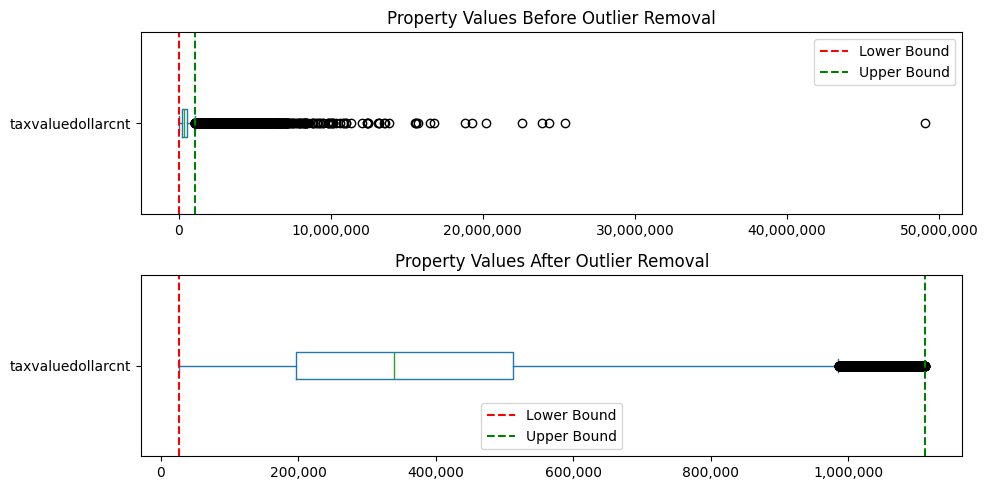

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

# Original data box plot with limits
df_original[target_col].plot(kind='box', vert=False, ax=axes[0])
axes[0].axvline(x=lower_bound, color='r', linestyle='--', label='Lower Bound')
axes[0].axvline(x=upper_bound, color='g', linestyle='--', label='Upper Bound')
axes[0].legend()
axes[0].set_title("Property Values Before Outlier Removal")
axes[0].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Data after outlier removal with same limit lines (for reference)
df_clean_deleted_outliers[target_col].plot(kind='box', vert=False, ax=axes[1])
axes[1].axvline(x=lower_bound, color='r', linestyle='--', label='Lower Bound')
axes[1].axvline(x=upper_bound, color='g', linestyle='--', label='Upper Bound')
axes[1].legend()
axes[1].set_title("Property Values After Outlier Removal")
axes[1].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()

As a result of outlier deletion, the box plot now shows a more compact range (topping out around the calculated upper bound) and reveals the distribution of the majority of properties more clearly. 
While the data remain right-skewed, the extreme outliers no longer obscure the main concentration of values in the lower and mid ranges.

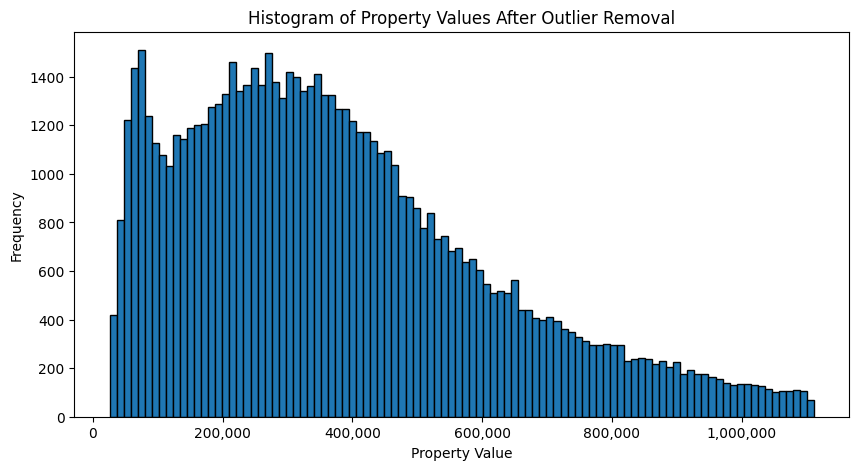

Minimum value of target: 25,875
Maximum value of target: 1,111,730


In [27]:
ax = df_clean_deleted_outliers[target_col].plot.hist(figsize=(10,5), bins=100, edgecolor='black')

# Use StrMethodFormatter to format the x-axis labels with commas
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.title("Histogram of Property Values After Outlier Removal")
plt.xlabel("Property Value")
plt.ylabel("Frequency")
plt.show()
min_val = df_clean_deleted_outliers[target_col].min()
max_val = df_clean_deleted_outliers[target_col].max()

print(f"Minimum value of target: {min_val:,.0f}")
print(f"Maximum value of target: {max_val:,.0f}")

The histogram is strongly right-skewed, with most properties in the 100k–400k range, peaking around 150–250k, and then gradually tapering off. 

After removing extreme outliers, the distribution extends to about 1 million, with fewer properties in the higher ranges. Overall, it remains **unimodal**, with a main peak in the lower-to-mid range and a tail toward higher prices.

We are planning to use tree-based models like **Random Forests**, which typically **handle skewed target distributions well** without requiring additional transformation. 

However, if we later decide to experiment with other modeling techniques that are more sensitive to target distribution, we may revisit and apply target transformation at that stage.


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


- Samples with excessive nulls:
  - We drop samples that have more than 60% missing values because such rows likely lack sufficient information to contribute meaningfully to the analysis or model training.

- Samples with missing target:
  - Any sample missing the target value is removed, as it cannot be used in supervised learning tasks where the target is required for training.

- Target outliers:
  - We removed samples that are outliers in the target variable (using the IQR method) because these extreme values might be due to data errors or represent atypical cases that could skew the model.


### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [28]:
def impute_columns(df, columns, method='mean', constant_value=None):
    """
    Impute missing values in specified columns of a DataFrame using a chosen method.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names to impute.
        method (str): Imputation method. Options are:
            - 'drop'     : Drop rows with missing values in the specified column(s).
            - 'mean'     : Fill missing values with the mean (numeric columns only).
            - 'median'   : Fill missing values with the median (numeric columns only).
            - 'mode'     : Fill missing values with the mode (most frequent value).
            - 'constant' : Fill missing values with a provided constant value (requires constant_value).
            - 'unknown'  : Fill missing values with the string "Unknown" (typically for categorical features).
        constant_value: The constant value to use when method is 'constant'.
        
    Returns:
        pd.DataFrame: A new DataFrame with the specified columns imputed.
    """
    df_imputed = df.copy()
    
    for col in columns:
        try:
            if col not in df_imputed.columns:
                print(f"Column '{col}' not found in DataFrame. Skipping.")
                continue
            
            if method == 'drop':
                # Drop rows with missing values for this column.
                df_imputed = df_imputed.dropna(subset=[col])
                print(f"Dropped missing values in column '{col}'.")
            
            elif method == 'mean':
                if pd.api.types.is_numeric_dtype(df_imputed[col]):
                    mean_val = df_imputed[col].mean()
                    df_imputed[col] = df_imputed[col].fillna(mean_val)
                    print(f"Filled missing values in column '{col}' with mean: {mean_val:,.2f}")
                else:
                    print(f"Column '{col}' is not numeric. Cannot apply mean imputation. Skipping.")
            
            elif method == 'median':
                if pd.api.types.is_numeric_dtype(df_imputed[col]):
                    median_val = df_imputed[col].median()
                    df_imputed[col] = df_imputed[col].fillna(median_val)
                    print(f"Filled missing values in column '{col}' with median: {median_val:,.2f}")
                else:
                    print(f"Column '{col}' is not numeric. Cannot apply median imputation. Skipping.")
            
            elif method == 'mode':
                mode_series = df_imputed[col].mode()
                if not mode_series.empty:
                    mode_val = mode_series.iloc[0]
                    df_imputed[col] = df_imputed[col].fillna(mode_val)
                    print(f"Filled missing values in column '{col}' with mode: {mode_val}")
                else:
                    print(f"Could not compute mode for column '{col}'. Skipping.")
            
            elif method == 'constant':
                if constant_value is None:
                    print(f"Constant value not provided for constant imputation on column '{col}'. Skipping.")
                else:
                    df_imputed[col] = df_imputed[col].fillna(constant_value)
                    print(f"Filled missing values in column '{col}' with constant value: {constant_value}")
            
            elif method == 'unknown':
                df_imputed[col] = df_imputed[col].fillna('Unknown')
                print(f"Filled missing values in column '{col}' with 'Unknown'.")
            
            else:
                print(f"Imputation method '{method}' is not supported for column '{col}'. Skipping.")
        
        except Exception as e:
            print(f"Error processing column '{col}': {e}")
    
    return df_imputed

# Example usage:
# df_imputed = impute_columns(df, ['column1', 'column2'], method='median')
# df_imputed = impute_columns(df, ['cat_column'], method='unknown')


In [29]:
df_clean = df_clean_deleted_outliers.copy()
# Check  missing values in remaining columns
missing_data = df_clean.isnull().sum()

missing_data[missing_data > 0].index.tolist()
# Impute missing values in numeric columns with mean
df_clean = impute_columns(df_clean, df_clean.select_dtypes(include=['number']).columns.tolist(), method='mean')



Filled missing values in column 'bathroomcnt' with mean: 2.20
Filled missing values in column 'bedroomcnt' with mean: 3.00
Filled missing values in column 'buildingqualitytypeid' with mean: 6.41
Filled missing values in column 'calculatedbathnbr' with mean: 2.21
Filled missing values in column 'calculatedfinishedsquarefeet' with mean: 1,663.12
Filled missing values in column 'finishedsquarefeet12' with mean: 1,634.80
Filled missing values in column 'fips' with mean: 6,048.94
Filled missing values in column 'fullbathcnt' with mean: 2.15
Filled missing values in column 'heatingorsystemtypeid' with mean: 4.01
Filled missing values in column 'lotsizesquarefeet' with mean: 30,547.93
Filled missing values in column 'propertylandusetypeid' with mean: 261.89
Filled missing values in column 'regionidcounty' with mean: 2,536.02
Filled missing values in column 'roomcnt' with mean: 1.50
Filled missing values in column 'unitcnt' with mean: 1.11
Filled missing values in column 'yearbuilt' with mean:

In [37]:
#######################################
# Impute missing values
#######################################

df_clean = df_clean_deleted_outliers.copy()

impute_columns_median = ['column1', 'column2']



df_imputed = impute_columns(df, ['column1', 'column2'], method='median')

Column 'column1' not found in DataFrame. Skipping.
Column 'column2' not found in DataFrame. Skipping.


#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [38]:
#######################################
# Encode categorical features
#######################################



# Create new features based on yearbuilt:
# Compute property age using 2016 as the assessment year
df_clean['propertyage'] = 2016 - df_clean['yearbuilt']

# Optionally, group yearbuilt by decade (e.g., 1900s, 1910s, etc.)
df_clean['yearbuilt_decade'] = (df_clean['yearbuilt'] // 10) * 10


## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

In [47]:
corr_matrix = df_clean.corr()
corr_matrix


,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,lotsizesquarefeet,propertylandusetypeid,regionidcounty,roomcnt,unitcnt,yearbuilt,taxvaluedollarcnt,propertyage,yearbuilt_decade
bathroomcnt,1.000000,0.611948,0.468343,1.000000,0.721072,0.739185,0.021550,0.980398,-0.323347,0.006246,-0.044164,-0.021850,0.055483,0.076906,0.377166,0.390977,-0.377166,0.370459
bedroomcnt,0.611948,1.000000,0.044250,0.593366,0.661595,0.675838,0.038084,0.586489,-0.146994,-0.116302,-0.288485,-0.008246,0.183903,0.105507,0.020265,0.226002,-0.020265,0.017290
buildingqualitytypeid,0.468343,0.044250,1.000000,0.467541,0.326699,0.419875,NaN,0.467541,-0.644008,0.129936,0.341101,NaN,NaN,-0.197953,0.598875,0.280577,-0.598875,0.592042
calculatedbathnbr,1.000000,0.593366,0.467541,1.000000,0.753660,0.746411,0.036285,0.980398,-0.323359,0.004963,-0.123076,-0.035920,0.048269,0.320871,0.378312,0.402704,-0.378312,0.371465
calculatedfinishedsquarefeet,0.721072,0.661595,0.326699,0.753660,1.000000,1.000000,0.075928,0.731790,-0.246527,-0.074267,-0.247992,-0.068761,0.140608,0.141214,0.192909,0.472678,-0.192909,0.187349
finishedsquarefeet12,0.739185,0.675838,0.419875,0.746411,1.000000,1.000000,0.103052,0.721158,-0.260640,-0.071685,-0.260376,-0.097610,0.175163,0.048813,0.252582,0.491398,-0.252582,0.246105
fips,0.021550,0.038084,NaN,0.036285,0.075928,0.103052,1.000000,-0.040750,0.600785,-0.087852,0.057569,-0.606736,0.709543,0.113024,0.229769,0.088306,-0.229769,0.227121
fullbathcnt,0.980398,0.586489,0.467541,0.980398,0.731790,0.721158,-0.040750,1.000000,-0.340711,0.015361,-0.140230,0.064847,-0.011232,0.320854,0.328688,0.374646,-0.328688,0.322566
heatingorsystemtypeid,-0.323347,-0.146994,-0.644008,-0.323359,-0.246527,-0.260640,0.600785,-0.340711,1.000000,-0.148611,-0.095290,-0.600785,0.551163,0.144007,-0.310317,-0.137071,0.310317,-0.305539
lotsizesquarefeet,0.006246,-0.116302,0.129936,0.004963,-0.074267,-0.071685,-0.087852,0.015361,-0.148611,1.000000,0.148966,0.111881,-0.092622,-0.020116,0.123185,-0.044668,-0.123185,0.123442


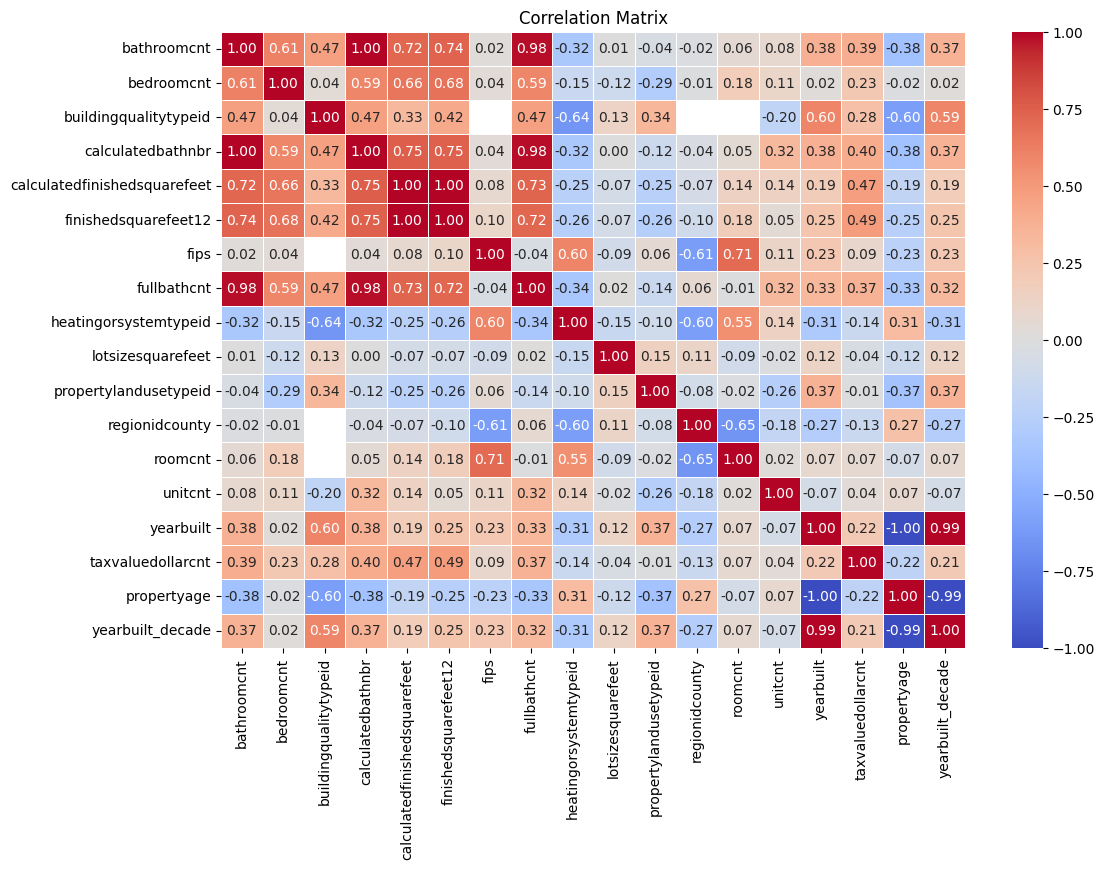

In [48]:
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

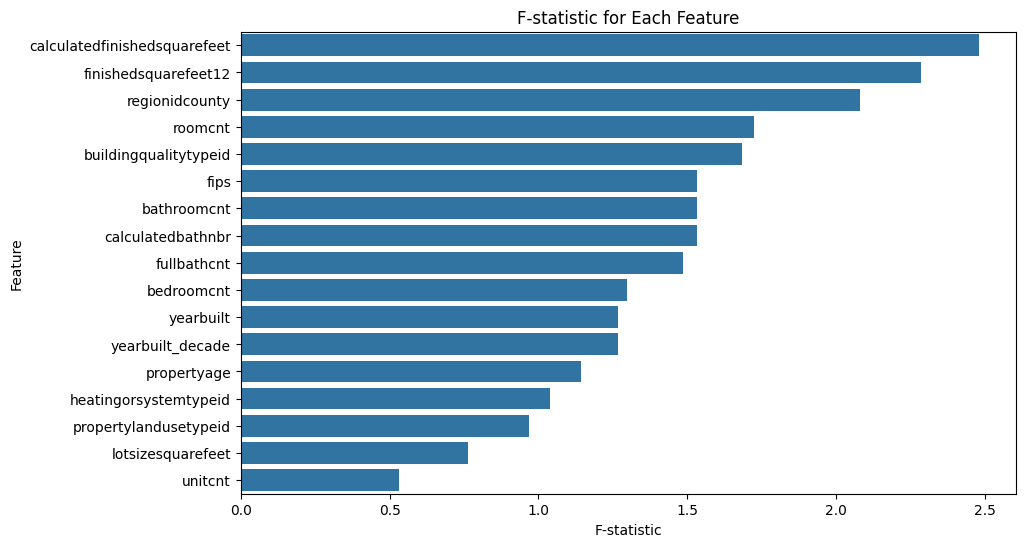

In [50]:
from sklearn.feature_selection import f_classif
X = df_clean.drop(columns='taxvaluedollarcnt').copy().fillna('0')
y = df_clean['taxvaluedollarcnt']
f_values, p_values = f_classif(X, y)
f_stat_df = pd.DataFrame({
    'Feature': X.columns,
    'F-statistic': f_values,
    'p-value': p_values
})

# Sort by F-statistic
f_stat_df = f_stat_df.sort_values(by='F-statistic', ascending=False)

# Plot F-statistic values in a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='F-statistic', y='Feature', data=f_stat_df)
plt.title('F-statistic for Each Feature')
plt.show()

In [52]:
# Forward Feature Selection

def forward_feature_selection(X, y, model, 
                              scoring='neg_mean_squared_error', 
                              cv=5, 
                              tol=None,               # None = no delta cutoff
                                                      # use 0.0 for "no further improvements"
                                                      # and 1e-4 for "point of diminishing returns"                                      
                              max_features=None,      # None = use all features
                              n_jobs=-1,
                              verbose=False
                             ):
    selected_features = []                            # List to store the order of features selected
    remaining_features = list(X.columns)              # Features not yet selected
    best_scores = []                                  # List to store the CV score after each feature addition
    previous_score = float('inf')                     # Initialize previous score for improvement comparison

    # Track the best subset of features and its corresponding score
    
    best_feature_set = None                           # Best combination of features found so far
    best_score = float('inf')                         # Best CV score observed so far
    
    while remaining_features:
        scores = {}                                   # Dictionary to hold CV scores for each candidate feature
        for feature in remaining_features:
            current_features = selected_features + [feature]
            
            # Compute the CV score for the current set of features (negated MSE, so lower is better)
            cv_score = -cross_val_score(model, X[current_features], y, 
                                        scoring=scoring, cv=cv, n_jobs=n_jobs
                                       ).mean()
            scores[feature] = cv_score

        # Select the feature that minimizes the CV score
        best_feature = min(scores, key=scores.get)
        current_score = scores[best_feature]
            
        # Check if the improvement is significant based on the tolerance (tol)
        if tol is not None and previous_score - current_score < tol:
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        # Add the best feature to the selected list and update score trackers
        selected_features.append(best_feature)
        best_scores.append(current_score)
        remaining_features.remove(best_feature)
        previous_score = current_score

        if verbose:
            print(f"\nFeatures: {selected_features[-3:]}, CV Score (MSE): {current_score:.4f}")
        
        # Update the best subset if the current score is better than the best so far
        if current_score < best_score:
            best_score = current_score
            best_feature_set = selected_features.copy()
        
        # Check if the maximum number of features has been reached
        if max_features is not None and len(selected_features) >= max_features:
            break

    return (
        selected_features,      # List of features in the order they were selected (this will be ALL features if max_features == None
        best_scores,            # List of cross-validation scores corresponding to each addition in the previous list
        best_feature_set,       # The subset of features that achieved the best CV score.
        best_score              # The best CV score
    )

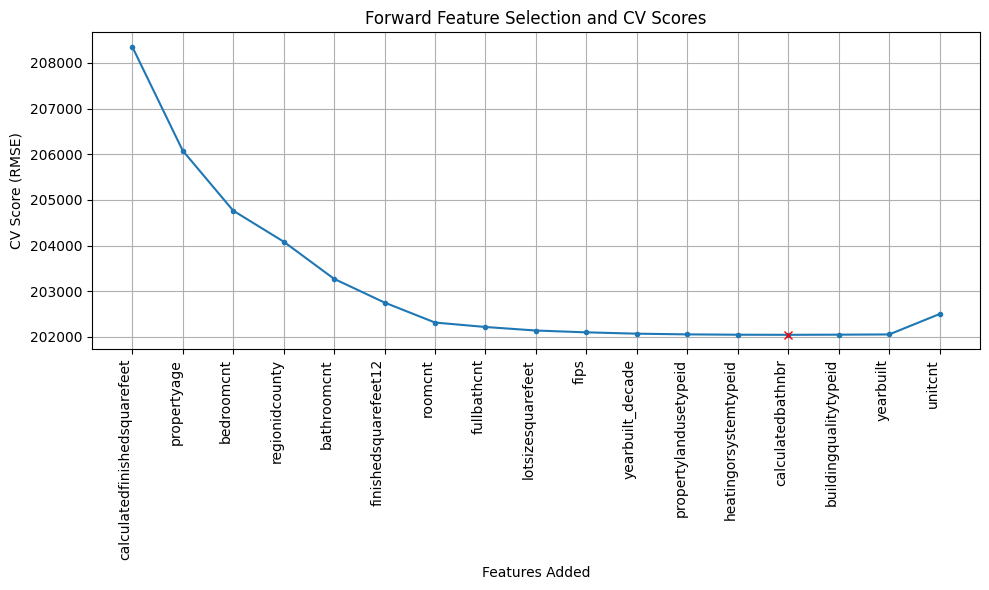

Best Features:['calculatedfinishedsquarefeet', 'propertyage', 'bedroomcnt', 'regionidcounty', 'bathroomcnt', 'finishedsquarefeet12', 'roomcnt', 'fullbathcnt', 'lotsizesquarefeet', 'fips', 'yearbuilt_decade', 'propertylandusetypeid', 'heatingorsystemtypeid', 'calculatedbathnbr']
Best CV Score:202046.5618


In [54]:
from sklearn.model_selection   import train_test_split, cross_val_score
from sklearn.linear_model      import LinearRegression,Ridge,Lasso
# Run Forward Feature Selection, plot the results, and print out the Best Feature Set and the Best CV Score found. 

selected_features, best_scores, best_feature_set, best_score = forward_feature_selection(
    X, y, model=LinearRegression()
)
# Convert MSE to RMSE
rmse_scores = [np.sqrt(score) for score in best_scores]
best_rmse = min(rmse_scores)
# Plot the results


index = np.argmax(np.array(selected_features) == best_feature_set[-1])

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rmse_scores) + 1), rmse_scores, marker='.')
plt.plot([index+1],best_rmse,marker='x',color='red')
plt.xticks(range(1, len(selected_features) + 1), selected_features, rotation=90, ha='right')
plt.title('Forward Feature Selection and CV Scores')
plt.xlabel('Features Added')
plt.ylabel('CV Score (RMSE)')
plt.grid()
plt.tight_layout()
plt.show()


print(f'Best Features:{best_feature_set}')
print(f'Best CV Score:{best_rmse:.4f}')

In [55]:
# Backward Feature Selection

def backward_feature_selection(X, y, model, 
                               scoring='neg_mean_squared_error', 
                               cv=5, 
                               tol=None,               # None = no delta cutoff
                                                       # use 0.0 for "no further improvements"
                                                       # and 1e-4 for "point of diminishing returns"                                      
                               max_features=None,      # If None, remove features until only 1 remains
                                                       # Otherwise, stop when this many features remain
                               n_jobs=-1,
                               verbose=False
                              ):
    
    # Helper function to compute CV score using LinearRegression
    def cv_score(features):
        return -cross_val_score(model, X[features], y, 
                                scoring=scoring, cv=cv, 
                                n_jobs=n_jobs          ).mean()
    
    # Start with all features (using a list for easier manipulation)
    features_remaining = list(X.columns)
    
    # Compute initial CV score with the full feature set
    initial_score = cv_score(features_remaining)
    
    # Initialize tracking variables
    best_score        = initial_score                # Best (lowest) CV score observed so far
    best_feature_set  = features_remaining.copy()    # Feature set corresponding to best_score
    selected_features = ['NONE']                     # List to record the order in which features are removed
    best_scores       = [initial_score]              # List to record the CV score after each removal (starting with full set)
    
    if verbose:
        print("Start with full set of features:")
        print(f'{features_remaining}  CV score (MSE): {np.around(initial_score, 4)}\n')
    
    # Determine the target number of features to keep:
    # For backward elimination, if max_features is None, we remove until 1 feature remains.
    target_feature_count = 1 if max_features is None else max_features
    
    prev_score = initial_score
    round_num = 1
    # Continue removing features until we reach the target count
    while len(features_remaining) > target_feature_count:
        if verbose:
            print(f'Round {round_num}:')
            
        # Initialize variables to track the best removal in this round
        lowest_score = float('inf')
        feature_to_remove = None
        best_new_features = None
        
        # Try removing each feature one at a time
        for feature in features_remaining:
            new_feature_set = features_remaining.copy()
            new_feature_set.remove(feature)
            new_score = cv_score(new_feature_set)
            if verbose:
                print('Trying removal of:',feature, np.around(new_score, 4))
            if new_score < lowest_score:
                lowest_score = new_score
                feature_to_remove = feature
                best_new_features = new_feature_set
        
        # Check if improvement is significant enough (if tol is set)
        if tol is not None and (prev_score - lowest_score) < tol:
            if verbose:
                print("\nStopping early due to minimal improvement.")
            break
        
        # Update the best score and feature set if current removal improves performance
        if lowest_score < best_score:
            best_score = lowest_score
            best_feature_set = best_new_features.copy()
        
        # Update trackers for this round
        prev_score = lowest_score
        features_remaining = best_new_features
        selected_features.append(feature_to_remove)
        best_scores.append(lowest_score)
        
        if verbose:
            print(f'\nRemoving {feature_to_remove}:  CV score (MSE) {np.around(lowest_score, 4)}\n')
        round_num += 1

    return (
        selected_features,      # Order in which features were removed
        best_scores,            # CV scores after each removal step
        best_feature_set,       # Feature set that achieved the best CV score
        best_score              # Best (lowest) CV score
    )

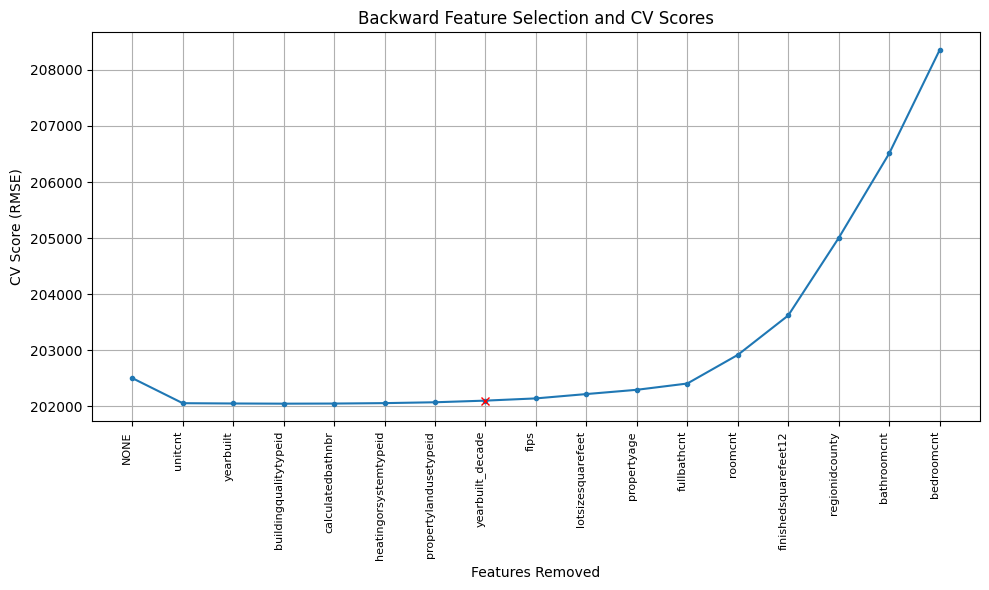

Best feature set: ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips', 'fullbathcnt', 'heatingorsystemtypeid', 'lotsizesquarefeet', 'propertylandusetypeid', 'regionidcounty', 'roomcnt', 'propertyage', 'yearbuilt_decade']
CV score (MSE): 202046.5618


In [56]:
#Run Backward Feature Selection, plot the results, and print out the Best Feature Set and the Best CV RMSE Score found. 
selected_features_backward, scores_backward, best_feature_set_backward, best_score_backward = backward_feature_selection(
    X, y, model= LinearRegression() )

# Convert MSE to RMSE for plotting
rmse_scores_backward = [np.sqrt(score) for score in scores_backward]
best_rmse_backward = min(rmse_scores_backward)

plt.figure(figsize=(10, 6))
plt.title('Backward Feature Selection and CV Scores')
plt.plot(range(1, len(rmse_scores_backward) + 1), rmse_scores_backward, marker='.')
index = np.argmax(np.array(selected_features_backward) == best_feature_set_backward[-1])
plt.plot([index + 1], rmse_scores_backward[index], marker='x', color='red')  
plt.xticks(range(1, len(selected_features_backward) + 1), selected_features_backward, rotation=90, ha='right', fontsize=8)
plt.xlabel('Features Removed')
plt.ylabel('CV Score (RMSE)')
plt.grid()
plt.tight_layout()
plt.show()


print("Best feature set:", best_feature_set_backward)
print("CV score (MSE):",np.around(best_rmse_backward,4))

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

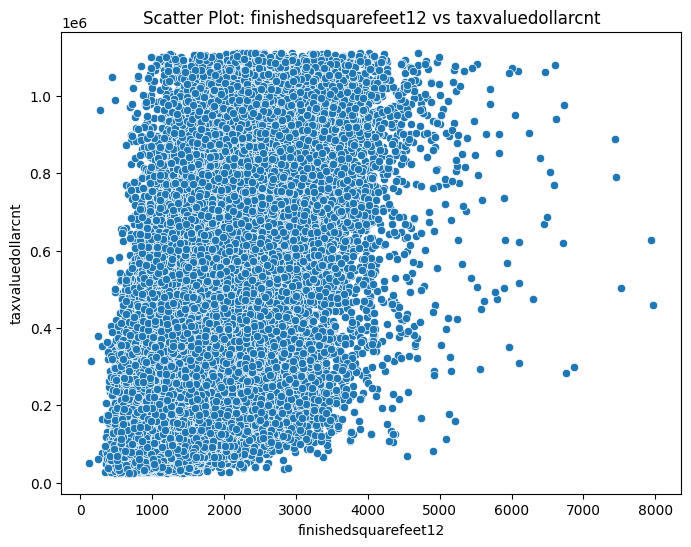

In [57]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_clean['finishedsquarefeet12'], y=df_clean['taxvaluedollarcnt'])
plt.title('Scatter Plot: finishedsquarefeet12 vs taxvaluedollarcnt')
plt.xlabel('finishedsquarefeet12')
plt.ylabel('taxvaluedollarcnt')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_clean['finishedsquarefeet12'], y=df_clean['taxvaluedollarcnt'])
plt.title('Scatter Plot: finishedsquarefeet12 vs taxvaluedollarcnt')
plt.xlabel('finishedsquarefeet12')
plt.ylabel('taxvaluedollarcnt')
plt.show()

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

